# Text Detection and OCR on Images

Text Detection and Recognition is one of the most valuable applications of Computer Vision Technology. In this notebook, we will implement this by using an image with text and running it through a text detection model to detect the presence of text in the image and then using a Convolutional Recurrent Neural Network to decode the data into actual text data to be interpreted by the user.
<hr style="border:2px solid gray"> </hr>

## Goal

## $~~~~~~~~~~~~~~~~~~~~$Input$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$Output
<img src ="visuals/english_signboard_recognised.jpg">   

## Workflow

- Import the libraries that is used for the program
- Import the image to detect the text
- Import the DB text detector module from the Open CV module to be used for detecting text
- Scale and resize the image to get it to the required size
- Apply text detector on the image to obtain the confusion matrix and the bounding box vertices of the text
- Draw bounding boxes over the detected text
- Iterate over the detected bounding boxes an scale it down and apply geometric transforms
- Use the text recognizer model over each of the detected roi to recognize the text
- Define a plain image and write the text on the image
- Concatenate the output and the input image

## Import the required libraries

All the function libraries that are needed in this code is imported here. Notable libraries :-
- cv2 :- Open CV computer vision library
- numpy :- High level mathematical library
- matplotlib :- Used for plotting and displaying images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['image.cmap'] = 'gray'

## Display Image to be used

Here, import the images to be used into using the imread method in the opencv library and display the images simultaneously using the imshow function in the matplotlib.pyplot library.Refer below to see the syntax :-

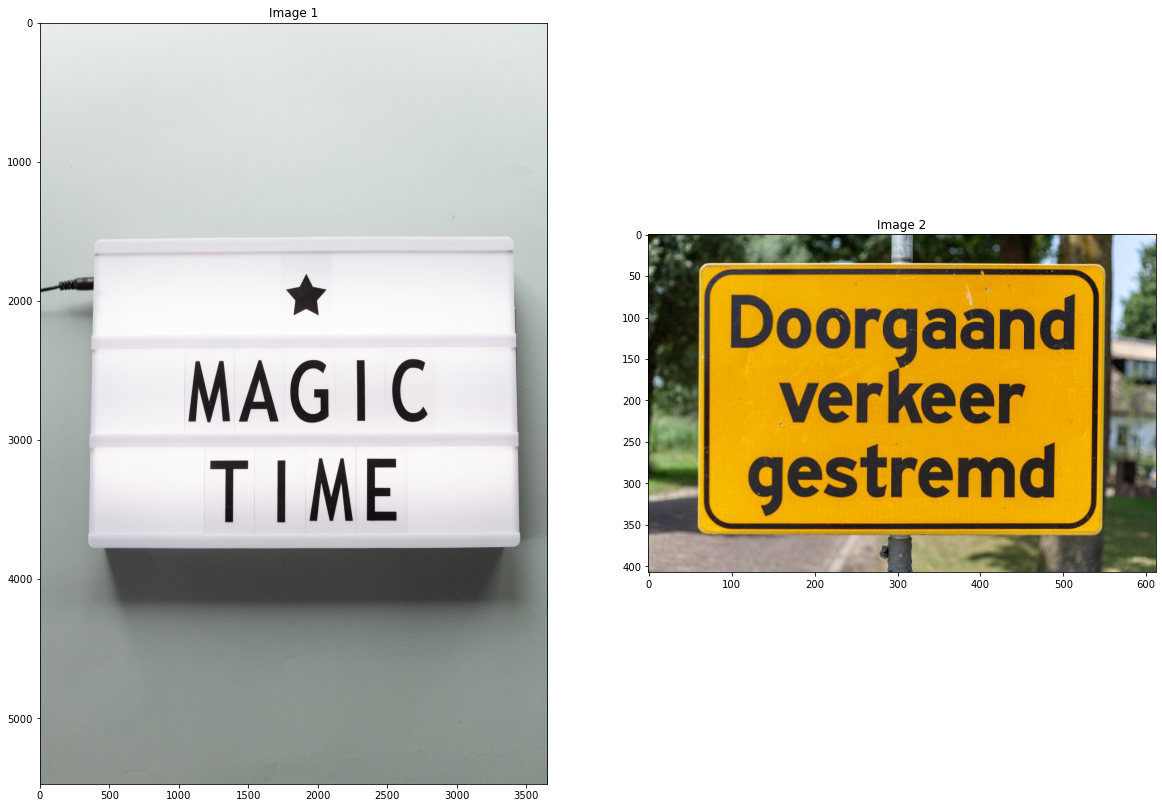

In [2]:
# Load Image
img1 = cv2.imread('./visuals/english_signboard.jpg')
img2 = cv2.imread('./visuals/dutch_signboard.jpg')

# Display the image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(img1[:,:,::-1]); plt.title('Image 1');
plt.subplot(122); plt.imshow(img2[:,:,::-1]); plt.title('Image 2');

## Import the Language Vocabulary to be used for the text recognition

### <font style="color:rgb(8,133,37)">The detected text in the image is converted into text data using this vocabulary as reference.</font>

In [3]:
# Define list to store the vocabulary in
vocabulary =[]
# Open file to import the vocabulary
with open("./resources/alphabet_94.txt") as f:
    # Read the file line by line
    for l in f:
        # Append each line into the vocabulary list.
        vocabulary.append(l.strip())
    #Close the file
    f.close()
print("Vocabulary:", vocabulary, len(vocabulary))

Vocabulary: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'] 94


## Import the prebuild text detection and text recognition model files

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

For the text detection in the image, we will be using the DB text detection deep learning neural network model.The DB text detector is a neural network that has been trained using images containing words and it detect the presence of text in the image to return the x,y values of vertices of ROI containing the text as its output.


[**`DB Text Detection Model()`**](https://docs.opencv.org/master/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html)

[**`Text Recognition Model()`**](https://docs.opencv.org/4.5.2/de/dee/classcv_1_1dnn_1_1TextRecognitionModel.html)

In [4]:
# DB model for text-detection based on resnet50
text_detector = cv2.dnn_TextDetectionModel_DB("resources/DB_TD500_resnet50.onnx")
binThresh = 0.3
polyThresh = 0.5
maxCandidates = 200
unclipRatio = 2.0

text_detector.setBinaryThreshold(binThresh).setPolygonThreshold(polyThresh).setMaxCandidates(maxCandidates).setUnclipRatio(unclipRatio)
text_detector.setInputParams(1.0/255, (736, 736), (122.67891434, 116.66876762, 104.00698793) , True)

In [5]:
# CRNN model for text-recognition
text_recogniser = cv2.dnn_TextRecognitionModel("./resources/crnn_cs.onnx")
text_recogniser.setDecodeType("CTC-greedy")
text_recogniser.setVocabulary(vocabulary)
text_recogniser.setInputParams(1/127.5, (100,32), (127.5, 127.5, 127.5))

## Funtion for transforming boxes

Geometric image transformation functions are used to straighten and apply perspective transform on the roi boxed detected by the DB text detector.

[**`Geometric Image Transforms()`**]
(https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html)

In [6]:
# This Function does transformation over the bounding boxes detected by the text detection model
def fourPointsTransform(frame, vertices):
    # Print vertices of each bounding box 
    vertices = np.asarray(vertices).astype(np.float32)
    outputSize = (100, 32)
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype="float32")
    # Apply perspective transform
    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    return result

## Set Scale Factor for resize 

Scaling factor is defined according to the input size of different images so that output scaled image of a standard size is obtained every time. 

In [7]:
# Defining function that returns the scale factor to resize the output image according to 
# the size/shape matrix of the input image
def setScaleFactor(frame):
    #Get image height and width
    frame_h, frame_w, ch = frame.shape
    # Define scaling factor according to preset values of the input image size so as 
    # the output image is scaled down to a generic size,"k" is the scaling factor value
    if (frame_h > 2000) and (frame_w > 2000):
        k = 0.2
    elif (2000 > frame_h > 1000) and 2000 > frame_w > 1000:
        k = 0.4
    elif (frame_h < 1000) or frame_w < 1000:
        k = 0.6
    elif (frame_h < 500) and frame_w < 500:
        k = 1
    else:
        k = 0.5
    return k

Text(0.5, 1.0, 'Image 1')

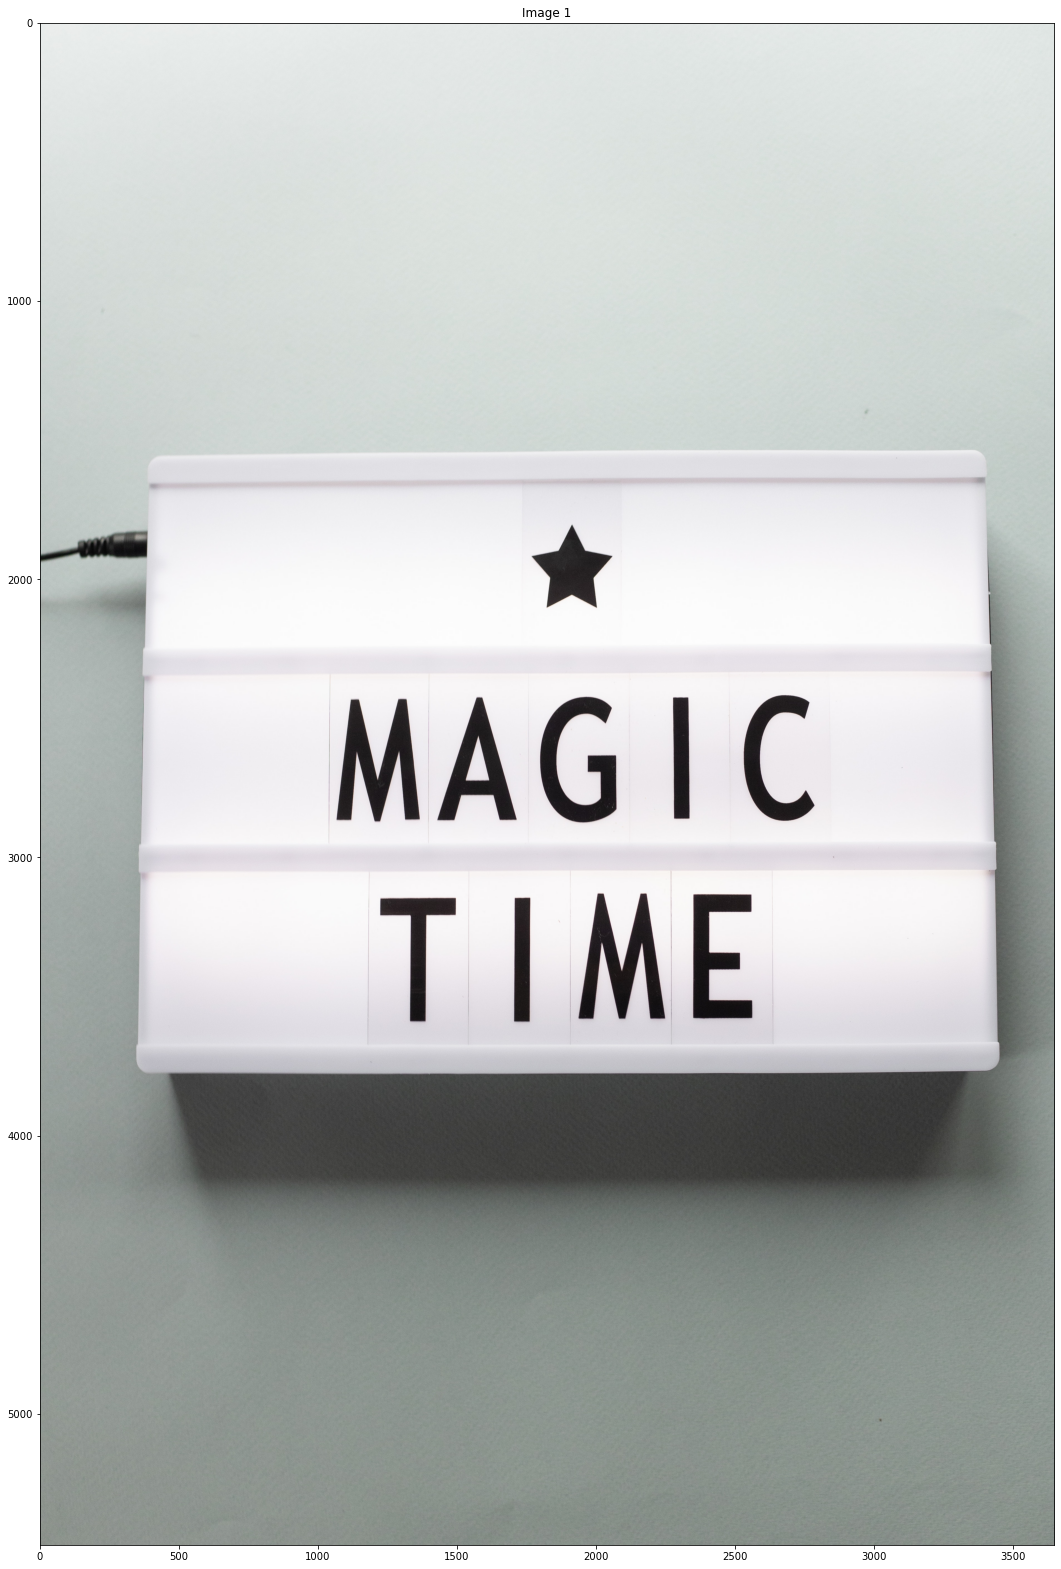

In [8]:
# Display input image file
plt.figure(figsize=(40,40))
plt.subplot(121); plt.imshow(img1[:,:,::-1]); plt.title('Image 1')

## Resize the input image
Notice that image-1 is quite large and has to be resized to a lower size to obtain an image in standard sized. We will be using the scaling factor set in the previous section to resize the image to required size

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>


[**`resize()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)

In [9]:
# Get the scaling factor
scaling_factor = setScaleFactor(img1)

Text(0.5, 1.0, 'Resized')

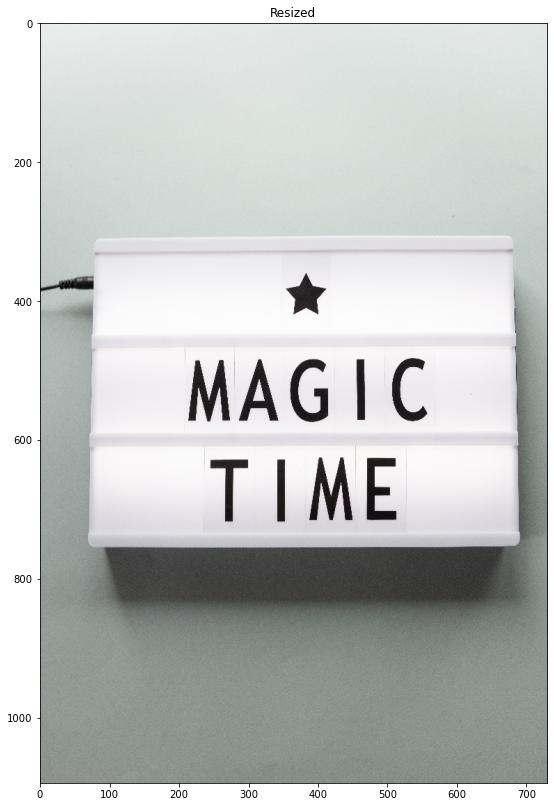

In [10]:
# Resize the image depending on the original image shape and the scaling factor
image = cv2.resize(img1, None, fx= scaling_factor, fy= scaling_factor, interpolation= cv2.INTER_LINEAR)
# Display resized image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.title('Resized')

In [11]:
# Create a blank matrix to be used to display the output image
image_white = np.full(image.shape[:3],255, dtype =np.uint8)

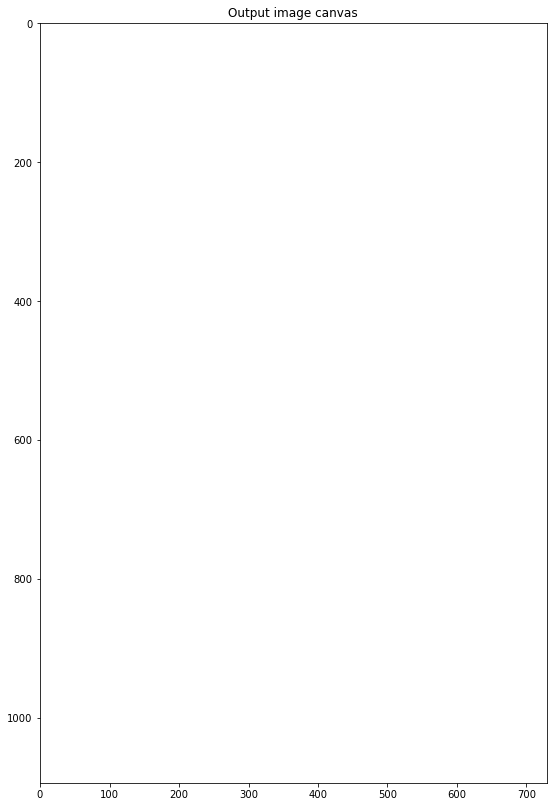

In [12]:
# Display the output image template
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(image_white[:,:,::-1]); plt.title('Output image canvas');

## Use DB text detector on the image

The DB text detector that is initialised previously in the program is applied on the image to detect text contained in the input image.Vertices of bounding boxes of roi containing text and its confusion matrix is given as output to the function.

In [13]:
# Use the DB text detector initialised previously to detect the presence of text in the image
boxes, confs = text_detector.detect(image)

## Iterate box by by box and use text recognizer on each text box

Iterate over the roi detected by the DB text detector and obtain the scaled roi area and vertices.Then we determine the scale of the output font on the output image and write down the detected text on the output image using the open cv puttext function to display the output text.

In [14]:
text_data=[]

# Iterate throught the bounding boxes detected by the text detector model
for box in boxes:
    
    # Apply transformation on the bounding box detected by the text detection algorithm
    cropped_roi  = fourPointsTransform(image,box)
    
    # Recognise the text using the crnn model
    recResult = text_recogniser.recognize(cropped_roi)
    
    # Get scaled values
    box_height = int((abs((box[0,1]-box[1,1]))))
    
    # Get scale of the font
    fontScale = cv2.getFontScaleFromHeight( cv2.FONT_HERSHEY_SIMPLEX, 
                                            box_height-20, 1 )
    
    # Write the recognised text on the output image
    cv2.putText(image_white, recResult, (int( box[0,0]),int( box[0,1])),
                cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 0,0), 1, 5)
    # Append recognised text to the data storage variable
    text_data.append(recResult)
# Joining the text data together to form a output sentence
text_data=' '.join(text_data)
print(text_data)

TIME MAGIC


## Draw the detected bounding boxes on original image

Plot the detected bounding boxes on the original image to show where the images are detected.

Text(0.5, 1.0, 'Bounding boxes')

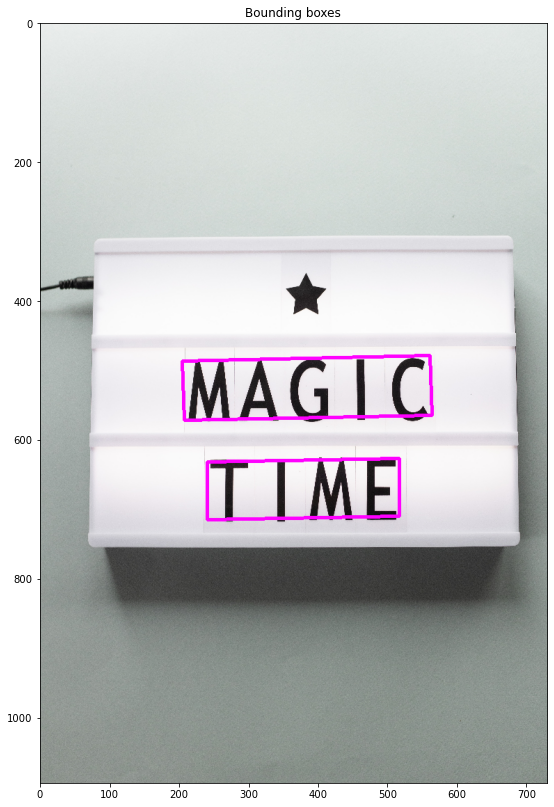

In [15]:
# Draw the bounding boxes of text detected.
cv2.polylines(image, boxes, True, (255, 0, 255), 4)
# Display the image with the bounding boxes drawn
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.title('Bounding boxes')

## Concatenate input and output images and display the output together

The input and output images are concatenated together to get a nice comparitive view of the process.

Text(0.5, 1.0, 'Output')

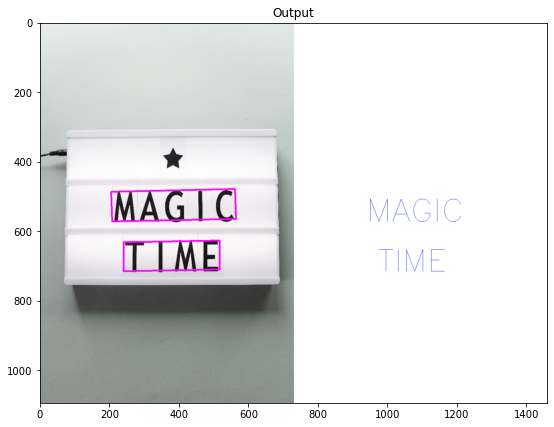

In [16]:
# Concatenate the input image with the output image
canvas = cv2.hconcat([image,image_white])
cv2.imwrite('visuals/english_signboard_recognised.jpg', canvas)
# Display the output Image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(canvas[:,:,::-1]); plt.title('Output')

In [17]:
def recognise_text(img):
    # Get the scaling factor
    scaling_factor = setScaleFactor(img)
    # Resize the image depending on the original image shape and the scaling factor
    image = cv2.resize(img, None, fx= scaling_factor, fy= scaling_factor, interpolation= cv2.INTER_LINEAR)

    # Create a blank matrix to be used to display the output image
    image_white = np.full(image.shape[:3],255, dtype =np.uint8)

    # Use the DB text detector initialised previously to detect the presence of text in the image
    boxes, confs = text_detector.detect(image)

    #Iterate throught the bounding boxes detected by the text detector model
    for box in boxes:

        # Apply transformation on the bounding box detected by the text detection algorithm
        cropped_roi  = fourPointsTransform(image,box)

        # Recognise the text using the crnn model
        recResult = text_recogniser.recognize(cropped_roi)

        # Get scaled values
        box_height = int((abs((box[0,1]-box[1,1]))))

        # Get scale of the font
        fontScale = cv2.getFontScaleFromHeight( cv2.FONT_HERSHEY_SIMPLEX, 
            box_height-20, 1 )

        # Write the recognised text on the output image
        cv2.putText(image_white, recResult, (int( box[0,0]),int( box[0,1])),
            cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 0,0), 1, 5)

    # Draw the bounding boxes of text detected.
    cv2.polylines(image, boxes, True, (255, 0, 255), 4)

    # Concatenate the input image with the output image
    canvas = cv2.hconcat([image,image_white])

    # Display the output Image
    plt.figure(figsize=(20,20))
    plt.subplot(121); plt.imshow(canvas[:,:,::-1]); plt.title('Output')

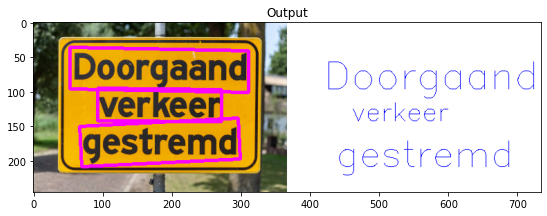

In [18]:
recognise_text(img2)

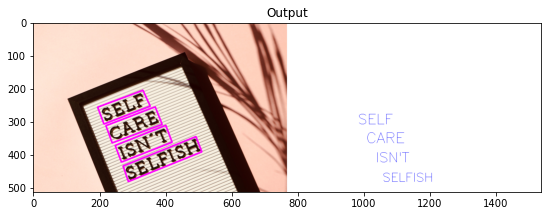

In [19]:
img3 = cv2.imread('./visuals/card.jpg')
recognise_text(img3)

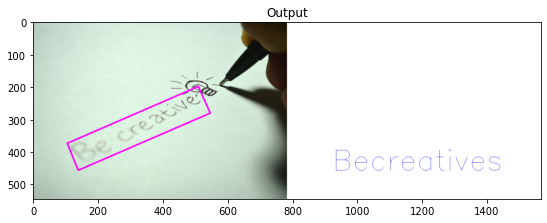

In [20]:
img4 = cv2.imread('./visuals/paper.jpg')
recognise_text(img4)




## Conslusion

Detection of text data in an image is done using DB text detection model and text recognition is done using the CRNN deep learning model.
<hr style="border:2px solid gray"> </hr>
